In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [27]:
gtmegye = pd.read_csv('GTrend_megye_aranyok1118.csv')

In [28]:
# no need with László's files, necessary with Miklós's output:
#gtmelt = pd.melt(gtmegye, id_vars=['honap','megye'], value_vars=['fidesz','lmp','mszp','jobbik','egyutt','momentum','pm','dk'])
#gtmelt.rename(columns={'variable':'part','value':'search_intensity'},inplace=True)
gtmelt = gtmegye.rename(columns={'Month':'honap','party':'szervezet'})

In [29]:
gtmelt['ev'],gtmelt['ho']=gtmelt['honap'].str.split('-').str

In [30]:
# need to ignore 2010 for now
gtmelt14 = gtmelt.loc[gtmelt['honap'].isin(['2014-01','2014-02','2014-03'])]

In [31]:
# not compatible with 2010
gtmelt14_nobal = gtmelt14.loc[~gtmelt14['szervezet'].isin(['mszp','egyutt','dk','pm'])]
gtmelt14_bal = gtmelt14.loc[gtmelt14['szervezet'].isin(['mszp','egyutt','dk','pm'])]

In [32]:
gtmelt14_bal = gtmelt14_bal.groupby(['honap','megye'])['search_intensity'].sum().reset_index()

In [33]:
gtmelt14_bal['szervezet'] = 'baloldal'

In [34]:
gtmelt14 = gtmelt14_nobal.append(gtmelt14_bal)

In [35]:
gtmelt14.head()

,ev,ho,honap,megye,search_intensity,szervezet
5762,2014,01,2014-01,1,0.240876,fidesz
5763,2014,01,2014-01,1,0.182482,jobbik
5764,2014,01,2014-01,1,0.072993,lmp
5765,2014,01,2014-01,1,0.000000,momentum
5770,2014,01,2014-01,2,0.154362,fidesz


In [36]:
gtmelt14.drop(columns='honap',inplace=True)

In [54]:
gt14_hopivot = gtmelt14.pivot_table(values='search_intensity', index=['ev', 'szervezet','megye'], columns='ho').reset_index()

## Missing:
-    MDF search for 2010 — de ha úgyis újra, akkor szűkebb időtartamra, és a két csúcspártot vagy a legkisebb nagypártot tartani a kispártosban?
-    civilek, mszdp, mp stb? UPDATE: max a civilek kellenek
-    set search intensity for dk to 0 before oct 22, 2011, set pm to 0 before feb 17, 2013, set együtt to 0 before oct 26, 2012?
-    kétfarkú?
-    megyei összesítés és arányok 2010
-    ridge vagy súlyozott ridge?

## 2010-es listás adatok -- SKIP

In [111]:
listas10 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/2010/listas.csv')

In [112]:
listas10.head()

,szavazokor,szavazat,part
0,M01/T001/001,76,M01/1
1,M01/T001/001,62,M01/2
2,M01/T001/001,86,M01/3
3,M01/T001/001,27,M01/4
4,M01/T001/001,332,M01/5


In [113]:
part_to_szervezet = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/2010/szervezet_shortname.csv')

In [114]:
part_to_szervezet.head()

,id,szervezet
0,M01/1,mszp
1,M01/2,jobbik
2,M01/3,lmp
3,M01/4,mdf
4,M01/5,fidesz


In [115]:
listas10 = listas10.merge(part_to_szervezet,left_on='part',right_on='id',copy=False)

In [127]:
listas10 = listas10[~listas10['szervezet'].isin(['miép','mp','mszdp'])]

In [117]:
listas10['megye']=listas10['id'].str.extract('M(\d\d)/.*').astype('uint8')

/Users/laszlo.sandor/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [118]:
listas10megyei = listas10.groupby(['megye','szervezet'])['szavazat'].sum()#.reset_index()

In [119]:
listas10megyeiaranyok = listas10megyei.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

In [120]:
listas10megyeiaranyok.head()

,megye,szervezet,szavazat
0,1,fidesz,0.463201
1,1,jobbik,0.108400
2,1,lmp,0.128115
3,1,mdf,0.046979
4,1,mszp,0.253305


## 2014-es listás adatok

In [38]:
listas14 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/jelolt/listas.csv')

In [42]:
part_to_szervezet14 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/jelolt/szervezet_shortname_2014.csv')

In [43]:
part_to_szervezet14.head()

,szervezet,id
0,mcp,1
1,eladó,2
2,seres,3
3,fkgp,4
4,údp,5


In [44]:
listas14 = listas14.merge(part_to_szervezet14,left_on='part',right_on='id',copy=False)

In [45]:
listas14.head()

,szavazokor,part,szavazat,szervezet,id
0,M01/T001/001,1,0,mcp,1
1,M01/T001/002,1,2,mcp,1
2,M01/T001/003,1,0,mcp,1
3,M01/T001/004,1,0,mcp,1
4,M01/T001/005,1,0,mcp,1


In [46]:
listas14 = listas14[~listas14['szervezet'].isin(['mcp','eladó','seres','fkgp','údp','sem','jesz','úmp','mp','szd','kti','együtt','zp','öf','total'])]

In [47]:
listas14['megye']=listas14['szavazokor'].str.extract('M(\d\d)/.*').astype('uint8')

/Users/laszlo.sandor/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [51]:
listas14megyei = listas14.groupby(['megye','szervezet'])['szavazat'].sum()

In [52]:
listas14megyeiaranyok = listas14megyei.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

In [53]:
listas14megyeiaranyok.head()

,megye,szervezet,szavazat
0,1,baloldal,0.381925
1,1,fidesz,0.399956
2,1,jobbik,0.125411
3,1,lmp,0.092708
4,2,baloldal,0.294771


In [55]:
ridgetable14 = listas14megyeiaranyok.merge(gt14_hopivot,on=['megye','szervezet'],validate='1:1',copy=False)

In [56]:
ridgetable14

,megye,szervezet,szavazat,ev,01,02,03
0,1,fidesz,0.399956,2014,0.240876,0.273224,0.251101
1,1,jobbik,0.125411,2014,0.182482,0.256831,0.317181
2,1,lmp,0.092708,2014,0.072993,0.087432,0.070485
3,2,fidesz,0.429807,2014,0.154362,0.238095,0.261745
4,2,jobbik,0.208965,2014,0.208054,0.291005,0.342282
5,2,lmp,0.066457,2014,0.114094,0.052910,0.080537
6,3,fidesz,0.522348,2014,0.310345,0.273196,0.285714
7,3,jobbik,0.219618,2014,0.241379,0.345361,0.309524
8,3,lmp,0.047394,2014,0.068966,0.061856,0.087302
9,4,fidesz,0.465176,2014,0.398496,0.453125,0.214953


## Fitting a ridge model
Considerations:
    - subtract national average poll numbers from March?

In [61]:
X = ridgetable14[['01','02','03']]
y = ridgetable14['szavazat']

In [91]:
alphas = np.logspace(-10, 2, 2000)

In [92]:
model1 = linear_model.RidgeCV(alphas, fit_intercept=False, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=True)
model1.fit(X,y)

RidgeCV(alphas=array([1.00000e-10, 1.01392e-10, ..., 9.86273e+01, 1.00000e+02]),
    cv=None, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [87]:
model1.coef_

array([0.78062888, 0.13555771, 0.21814365])

In [94]:
model1.alpha_

0.12093200981435695

In [95]:
mses_by_alphas = model1.cv_values_.mean(axis=0)

In [98]:
2*np.sqrt(mses_by_alphas.min())

0.23179972894056747

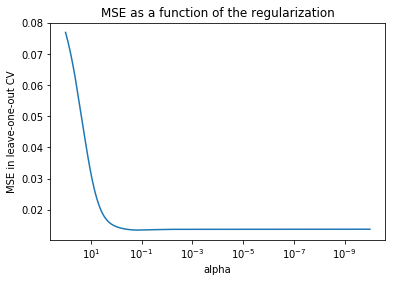

In [96]:
# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, mses_by_alphas)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('MSE in leave-one-out CV')
plt.title('MSE as a function of the regularization')
plt.axis('tight')
plt.show()

### Explore coefs in terms of regularization

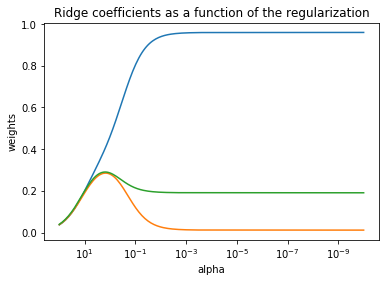

In [76]:
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()